In [1]:
import sys
sys.path.append("../")

In [22]:
from mir.common.parser import *
from mir.common.repertoire import Repertoire
from mir.common.repertoire_dataset import RepertoireDataset
from mir.common.clonotype_dataset import ClonotypeDataset
from mir.basic.segment_usage import *
from mir.basic.sampling import RepertoireSampling
from pympler.asizeof import asizeof
from mir.biomarkers.fisher_biomarkers_detector import FisherBiomarkersDetector
import time

In [3]:
metadata = pd.read_csv('assets/samples/fmba_healthy/desc_fmba_beta_healthy_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
metadata

,run,reads,clonotypes,folder,HLA-A.1,HLA-A.2,HLA-B.1,HLA-B.2,HLA-C.1,HLA-C.2,HLA-DPB1.1,HLA-DPB1.2,HLA-DQB1.1,HLA-DQB1.2,HLA-DRB1.1,HLA-DRB1.2,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1
0,020000330101_S185_L002.clonotypes.TRB.txt,4558846,10762,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*02:06,B*37:01,B*51:01,C*02:02,C*06:02,DPB1*03:01,DPB1*04:02,DQB1*03:01,DQB1*06:01,DRB1*08:03,DRB1*11:01,NaN,NaN,NaN
1,020003810808_S104_L002.clonotypes.TRB.txt,3117991,15211,2020/10_FMBA_NovaSeq5,A*01:02,A*31:01,B*07:02,B*15:16,C*07:02,C*14:02,DPB1*02:01,DPB1*04:01,DQB1*02:01,DQB1*06:02,DRB1*03:01,DRB1*15:01,NaN,NaN,NaN
2,020003840808_S118_L002.clonotypes.TRB.txt,1894167,8435,2020/10_FMBA_NovaSeq5,A*01:01,A*02:01,B*13:02,B*44:02,C*06:02,C*07:04,DPB1*03:01,DPB1*17:01,DQB1*02:02,DQB1*06:02,DRB1*07:01,DRB1*15:01,NaN,NaN,NaN
3,050000310808_S83_L001.clonotypes.TRB.txt,1407629,16454,2020/12_FMBA_Novaseq7_DNA,A*02:01,A*02:01,B*13:02,B*51:01,C*06:02,C*07:02,DPB1*04:01,DPB1*05:01,DQB1*02:02,DQB1*03:02,DRB1*04:03,DRB1*07:01,NaN,NaN,NaN
4,050000550101_S84_L001.clonotypes.TRB.txt,4039131,31101,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*02:01,B*50:01,B*51:01,C*03:03,C*08:03,DPB1*04:01,DPB1*05:01,DQB1*02:02,DQB1*03:03,DRB1*07:01,DRB1*09:01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,780003220808_S28_L001.clonotypes.TRB.txt,4494229,5699,2020/10_FMBA_NovaSeq4,A*01:01,A*02:01,B*38:01,B*56:01,C*01:02,C*12:03,DPB1*04:01,DPB1*04:01,DQB1*02:01,DQB1*06:03,DRB1*03:01,DRB1*13:01,NaN,NaN,NaN
79,780003440101_S87_L001.clonotypes.TRB.txt,2847425,17997,2020/12_FMBA_Novaseq8_DNA,A*02:01,A*30:01,B*13:02,B*41:02,C*06:02,C*17:03,DPB1*02:01,DPB1*04:01,DQB1*02:02,DQB1*03:01,DRB1*07:01,DRB1*11:01,NaN,NaN,NaN
80,780003510808_S92_L001.clonotypes.TRB.txt,567555,3645,2020/10_FMBA_NovaSeq4,A*25:01,A*26:01,B*07:02,B*57:01,C*06:02,C*07:02,DPB1*04:01,DPB1*11:01,DQB1*02:02,DQB1*03:03,DRB1*07:01,DRB1*07:01,NaN,NaN,NaN
81,780003930808_S76_L001.clonotypes.TRB.txt,224067,3609,2020/10_FMBA_NovaSeq4,A*03:01,A*26:01,B*18:01,B*35:01,C*04:01,C*07:01,DPB1*04:01,DPB1*04:02,DQB1*03:01,DQB1*05:01,DRB1*01:01,DRB1*11:04,NaN,NaN,NaN


In [4]:
t0 = time.time()
dataset = RepertoireDataset.load(parser=VDJtoolsParser(sep=','), 
                                 metadata=metadata,
                                 threads=32,
                                 paths=[f'assets/samples/fmba_healthy/{r["run"]}.gz' for _, r in metadata.iterrows()])
print(time.time() - t0)

there are 82314 public clonotypes


clonotype usage matrix preparation: 100%|██████████| 32/32 [00:19<00:00,  1.60it/s]


69.83716750144958


In [5]:
folder_to_run_mapping = {}
for folder in dataset.metadata[['run', 'folder']].folder.unique():
    folder_to_run_mapping[folder] = set(dataset.metadata[dataset.metadata.folder == folder].run)

In [6]:
z_score_usage_table_v = StandardizedSegmentUsageTable.load_from_repertoire_dataset(
    repertoire_dataset=dataset, 
    gene='TRB', 
    segment_type='V', 
    group_mapping=folder_to_run_mapping, 
    standardization_method='log_exp')
z_score_usage_table_j = StandardizedSegmentUsageTable.load_from_repertoire_dataset(
    repertoire_dataset=dataset, 
    gene='TRB', 
    segment_type='J', 
    group_mapping=folder_to_run_mapping, 
    standardization_method='log_exp')

In [7]:
t0 = time.time()
dataset = dataset.resample(updated_segment_usage_tables=[z_score_usage_table_v, z_score_usage_table_j], 
                                    threads=32)
print(time.time() - t0)

repertoire resampling in progress: 100%|██████████| 83/83 [00:24<00:00,  3.33it/s]


there are 73997 public clonotypes


clonotype usage matrix preparation: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


78.8070764541626


In [8]:
dataset

There are 83 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020000330101_S185_L002.clonotypes.TRB.txt  4558846       10762   
1  020003810808_S104_L002.clonotypes.TRB.txt  3117991       15211   
2  020003840808_S118_L002.clonotypes.TRB.txt  1894167        8435   
3   050000310808_S83_L001.clonotypes.TRB.txt  1407629       16454   
4   050000550101_S84_L001.clonotypes.TRB.txt  4039131       31101   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:06  B*37:01  B*51:01  C*02:02   
1      2020/10_FMBA_NovaSeq5  A*01:02  A*31:01  B*07:02  B*15:16  C*07:02   
2      2020/10_FMBA_NovaSeq5  A*01:01  A*02:01  B*13:02  B*44:02  C*06:02   
3  2020/12_FMBA_Novaseq7_DNA  A*02:01  A*02:01  B*13:02  B*51:01  C*06:02   
4  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:01  B*50:01  B*51:01  C*03:03   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*06:

In [9]:
dataset.clonotype_usage_matrix.clonotype_database_usage

<83x73997 sparse matrix of type '<class 'numpy.float64'>'
	with 1507267 stored elements in Compressed Sparse Column format>

In [23]:
asizeof(dataset.clonotype_usage_matrix.clonotype_database_usage)

18384576

In [10]:
a02_pos_rd, a02_neg_rd = dataset.split_by_metadata_function(
        splitting_method=lambda x: ('A*02' in x['HLA-A.1']) | ('A*02' in x['HLA-A.2'])
    )

there are 34358 public clonotypes


clonotype usage matrix preparation: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


there are 27636 public clonotypes


clonotype usage matrix preparation: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


In [11]:
a02_pos_rd

There are 47 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020000330101_S185_L002.clonotypes.TRB.txt  4558846       10762   
1  020003840808_S118_L002.clonotypes.TRB.txt  1894167        8435   
2   050000310808_S83_L001.clonotypes.TRB.txt  1407629       16454   
3   050000550101_S84_L001.clonotypes.TRB.txt  4039131       31101   
4   050000740101_S76_L001.clonotypes.TRB.txt  4541635       20570   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:06  B*37:01  B*51:01  C*02:02   
1      2020/10_FMBA_NovaSeq5  A*01:01  A*02:01  B*13:02  B*44:02  C*06:02   
2  2020/12_FMBA_Novaseq7_DNA  A*02:01  A*02:01  B*13:02  B*51:01  C*06:02   
3  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*02:01  B*50:01  B*51:01  C*03:03   
4  2020/12_FMBA_Novaseq8_DNA  A*02:01  A*03:01  B*27:05  B*35:01  C*01:02   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*06:

In [12]:
a02_neg_rd

There are 36 repertoires in the dataset
                                         run    reads  clonotypes  \
0  020003810808_S104_L002.clonotypes.TRB.txt  3117991       15211   
1  210001740808_S153_L002.clonotypes.TRB.txt  7783196       14797   
2   210002270101_S70_L001.clonotypes.TRB.txt  4197826       29344   
3   210003070808_S84_L001.clonotypes.TRB.txt  4902255       12855   
4   270000130807_S31_L001.clonotypes.TRB.txt  7782061       22626   

                      folder  HLA-A.1  HLA-A.2  HLA-B.1  HLA-B.2  HLA-C.1  \
0      2020/10_FMBA_NovaSeq5  A*01:02  A*31:01  B*07:02  B*15:16  C*07:02   
1      2020/10_FMBA_NovaSeq4  A*29:02  A*30:01  B*13:02  B*51:08  C*06:02   
2  2020/12_FMBA_Novaseq8_DNA  A*03:01  A*03:01  B*35:01  B*40:02  C*03:03   
3      2020/10_FMBA_NovaSeq4  A*24:02  A*26:01  B*27:14  B*35:02  C*01:02   
4      2020/10_FMBA_NovaSeq6  A*01:01  A*30:01  B*08:01  B*13:02  C*06:02   

   HLA-C.2  HLA-DPB1.1  HLA-DPB1.2  HLA-DQB1.1  HLA-DQB1.2  HLA-DRB1.1  \
0  C*14:

In [13]:
fbd = FisherBiomarkersDetector(control_repertoire_dataset=a02_pos_rd,
                               ill_repertoire_dataset=a02_neg_rd, 
                               adjusted_p_value=0.05, 
                               threads=28)

created a fisher biomarker detector with 28 threads


In [14]:
t0 = time.time()
biomarkers = fbd.detect_biomarkers(adjusted_p_value=0.0005)
print(time.time() - t0)

there are 56201 public clonotypes in ill repertoire


/home/evlasova/mirpy/notebooks/../mir/biomarkers/fisher_biomarkers_detector.py:75: TqdmWarning: Iterable length 56201 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  process_map(get_p_value_for_one_clonotype,
fisher testing in progress: 100%|██████████| 56201/56201 [00:12<00:00, 4624.05it/s]


104.38079237937927


In [15]:
a02_pos_rd.clonotype_usage_matrix.clonotype_database_usage

<47x34358 sparse matrix of type '<class 'numpy.float64'>'
	with 471143 stored elements in Compressed Sparse Column format>

In [16]:
import importlib
imported_module = importlib.import_module("mir.basic.clonotype_usage")
importlib.reload(imported_module)
from mir.basic.clonotype_usage import ClonotypeUsageTable

In [17]:
cd = ClonotypeDataset(clonotypes=[ClonotypeAA(cdr3aa=x) for x in biomarkers])

In [18]:
cd.clonotype_clustering

,cdr3aa,cluster
vertex ID,,
0,CASSPGTDNQPQHF,0
1,CASSLGTDNQPQHF,0
2,CASSPGQDNQPQHF,0
3,CASSPGTANQPQHF,0
4,CASSVLGSSYNEQFF,1
...,...,...
8180,CASSSLAGGRDTQYF,1809
8181,CASSFDRATDTQYF,1810
8182,CASSSTSGGSYEQYF,1811


In [19]:
cd.clonotype_clustering.cluster.value_counts()

cluster
22      486
13      450
14      296
26      292
16      287
       ... 
1772      1
1773      1
1774      1
1775      1
1776      1
Name: count, Length: 1814, dtype: int64

/home/evlasova/mirpy/notebooks/../mir/common/clonotype_dataset.py:160: UserWarning: 
The palette list has fewer values (100) than needed (743) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(plotting_df[plotting_df.cluster_size > 1], x='x', y='y', hue=color_by,


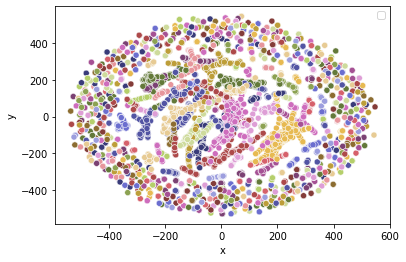

In [20]:
fig, ax = plt.subplots()
cd.plot_clonotype_clustering(color_by='cluster', ax=ax, plot_unclustered=False)
ax.legend([])